# Inter-Model Evaluation Analysis

This notebook performs aggregate inter-model evaluation analysis across all jobs in `data/local/`.

**Analysis Scope:**
- Auto-discovers all jobs in data/local/
- Aggregates metrics across all jobs
- Provides detailed tables and visualizations
- Focuses on model comparison, field types, pass trends, and low agreement fields

**Generated:** (run notebook to see timestamp)

## 1. Setup & Imports

In [72]:
# Data processing
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from pathlib import Path
import json
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation modules
import sys
sys.path.append(str(Path.cwd().parent))

from src.evaluation.evaluator import evaluate_job
from src.evaluation.models import JobEvaluation, FieldEvaluation, ModelPerformance
from src.evaluation.loader import MODEL_NAMES
from src.evaluation.field_registry import PASS1_FIELDS, PASS2_FIELDS, PASS3_FIELDS

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ All imports successful")
print(f"Analysis started at: {datetime.now()}")

✓ All imports successful
Analysis started at: 2025-12-11 20:40:12.549321


## 2. Data Discovery & Loading

In [73]:
def discover_and_evaluate_jobs(base_path=None):
    """
    Auto-discover and evaluate all jobs in data/local directory.
    
    Returns:
        tuple: (list of JobEvaluation objects, metadata dict)
    """
    # Use project root relative path
    if base_path is None:
        base_path = Path(__file__).parent.parent / "data" / "local" / "ai_enrichment" / "bronze" if "__file__" in dir() else Path.cwd().parent / "data" / "local" / "ai_enrichment" / "bronze"
    
    data_path = Path(base_path)
    
    if not data_path.exists():
        raise FileNotFoundError(f"Data path not found: {data_path}")
    
    # Discover job directories
    job_dirs = [d for d in data_path.iterdir() if d.is_dir() and d.name.isdigit()]
    job_ids = sorted([d.name for d in job_dirs])
    
    print(f"Found {len(job_ids)} job(s): {job_ids}")
    
    # Evaluate each job
    job_evals = []
    failed_jobs = []
    
    for job_id in job_ids:
        try:
            print(f"Evaluating job {job_id}...", end=" ")
            eval_result = evaluate_job(job_id, str(data_path))
            job_evals.append(eval_result)
            print("✓")
        except Exception as e:
            print(f"✗ Error: {e}")
            failed_jobs.append((job_id, str(e)))
    
    metadata = {
        'total_discovered': len(job_ids),
        'successfully_evaluated': len(job_evals),
        'failed': len(failed_jobs),
        'job_ids': job_ids,
        'failed_jobs': failed_jobs,
        'evaluated_at': datetime.now()
    }
    
    return job_evals, metadata

# Execute discovery and evaluation
job_evaluations, metadata = discover_and_evaluate_jobs()

print(f"\n{'='*60}")
print(f"Successfully evaluated: {metadata['successfully_evaluated']} job(s)")
print(f"Failed: {metadata['failed']} job(s)")
if metadata['failed_jobs']:
    print(f"Failed jobs: {[job[0] for job in metadata['failed_jobs']]}")
print(f"{'='*60}")

Found 99 job(s): ['4201877691', '4296706724', '4323400548', '4324537833', '4325749223', '4325749256', '4325749282', '4325757965', '4325758017', '4325797974', '4325797989', '4325797999', '4325798016', '4325827765', '4325829597', '4325837799', '4325837801', '4325837849', '4325839660', '4325839911', '4325847950', '4325847980', '4325867761', '4325877584', '4325887575', '4325889818', '4325897727', '4325897729', '4325897739', '4325897773', '4325917532', '4325937346', '4325939213', '4325939525', '4325948158', '4325956060', '4325965805', '4325984433', '4325984442', '4325994251', '4325994254', '4326002945', '4326002990', '4326005551', '4342313220', '4342322878', '4342322887', '4342323073', '4342372882', '4342392803', '4342392804', '4342402885', '4342432684', '4342452381', '4342482339', '4342482388', '4342522291', '4342532184', '4348287826', '4348519226', '4348519247', '4348519696', '4348519697', '4348528220', '4348528723', '4348538101', '4348538102', '4348538137', '4348538586', '4348547759', '4

## 3. Aggregate Metrics Computation

In [74]:
def compute_overall_metrics(job_evals):
    """
    Compute overall consensus metrics across all jobs.
    """
    if not job_evals:
        return {}
    
    # Aggregate consensus rates
    overall_rates = []
    pass1_rates = []
    pass2_rates = []
    pass3_rates = []
    total_fields = 0
    
    for job_eval in job_evals:
        overall_rates.append(job_eval.overall_consensus_rate)
        pass1_rates.append(job_eval.pass1_consensus_rate)
        pass2_rates.append(job_eval.pass2_consensus_rate)
        pass3_rates.append(job_eval.pass3_consensus_rate)
        total_fields += len(job_eval.field_evaluations)
    
    return {
        'overall_consensus_rate': np.mean(overall_rates),
        'pass1_consensus_rate': np.mean(pass1_rates),
        'pass2_consensus_rate': np.mean(pass2_rates),
        'pass3_consensus_rate': np.mean(pass3_rates),
        'consensus_distribution': overall_rates,
        'total_jobs': len(job_evals),
        'total_fields': total_fields,
        'avg_fields_per_job': total_fields / len(job_evals)
    }

overall_metrics = compute_overall_metrics(job_evaluations)
print("✓ Overall metrics computed")

✓ Overall metrics computed


In [75]:
def compute_field_type_metrics(job_evals):
    """
    Compute field type performance metrics across all jobs.
    """
    field_type_data = defaultdict(lambda: {'count': 0, 'with_consensus': 0, 'agreements': []})
    
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            ft = field_eval.field_type
            field_type_data[ft]['count'] += 1
            if field_eval.has_consensus:
                field_type_data[ft]['with_consensus'] += 1
            field_type_data[ft]['agreements'].append(field_eval.agreement_rate)
    
    # Convert to DataFrame
    rows = []
    for ft, data in field_type_data.items():
        rows.append({
            'field_type': ft,
            'total_count': data['count'],
            'with_consensus': data['with_consensus'],
            'consensus_rate': data['with_consensus'] / data['count'] if data['count'] > 0 else 0,
            'avg_agreement': np.mean(data['agreements']) if data['agreements'] else 0
        })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('avg_agreement', ascending=False)
    
    return df

field_type_metrics = compute_field_type_metrics(job_evaluations)
print("✓ Field type metrics computed")

✓ Field type metrics computed


In [76]:
def compute_model_performance_aggregate(job_evals):
    """
    Compute aggregate model performance across all jobs.
    """
    model_data = defaultdict(lambda: {
        'agreements': [],
        'pass1_agreements': [],
        'pass2_agreements': [],
        'pass3_agreements': [],
        'outlier_rates': []
    })
    
    for job_eval in job_evals:
        for model_id, perf in job_eval.model_performance.items():
            model_data[model_id]['agreements'].append(perf.agreement_rate)
            model_data[model_id]['pass1_agreements'].append(perf.pass1_agreement)
            model_data[model_id]['pass2_agreements'].append(perf.pass2_agreement)
            model_data[model_id]['pass3_agreements'].append(perf.pass3_agreement)
            model_data[model_id]['outlier_rates'].append(perf.outlier_rate)
    
    # Convert to DataFrame
    rows = []
    for model_id, data in model_data.items():
        avg_agreement = np.mean(data['agreements'])
        avg_outlier_rate = np.mean(data['outlier_rates'])
        
        # Calculate intermodel score (formula from report.py)
        intermodel_score = (avg_agreement * 0.6 + (1 - avg_outlier_rate) * 0.4) * 100
        
        rows.append({
            'model_id': model_id,
            'model_name': MODEL_NAMES.get(model_id, model_id),
            'avg_agreement': avg_agreement,
            'pass1_agreement': np.mean(data['pass1_agreements']),
            'pass2_agreement': np.mean(data['pass2_agreements']),
            'pass3_agreement': np.mean(data['pass3_agreements']),
            'outlier_rate': avg_outlier_rate,
            'intermodel_score': intermodel_score
        })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('intermodel_score', ascending=False)
    
    return df

model_performance = compute_model_performance_aggregate(job_evaluations)
print("✓ Model performance metrics computed")

✓ Model performance metrics computed


In [77]:
def compute_pass_trends(job_evals):
    """
    Compute pass-by-pass consensus trends for each job.
    """
    rows = []
    for job_eval in job_evals:
        rows.append({
            'job_id': job_eval.job_id,
            'job_title': job_eval.job_title,
            'company': job_eval.company_name,
            'pass1_rate': job_eval.pass1_consensus_rate,
            'pass2_rate': job_eval.pass2_consensus_rate,
            'pass3_rate': job_eval.pass3_consensus_rate,
            'overall_rate': job_eval.overall_consensus_rate
        })
    
    return pd.DataFrame(rows)

pass_trends = compute_pass_trends(job_evaluations)
print("✓ Pass trends computed")

✓ Pass trends computed


In [78]:
def identify_low_agreement_fields(job_evals, threshold=0.5):
    """
    Identify fields with consistently low agreement across jobs.
    """
    field_data = defaultdict(lambda: {'agreements': [], 'field_type': None, 'pass': None, 'outlier_models': []})
    
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            field_name = field_eval.field_name
            field_data[field_name]['agreements'].append(field_eval.agreement_rate)
            field_data[field_name]['field_type'] = field_eval.field_type
            field_data[field_name]['pass'] = field_eval.pass_number
            field_data[field_name]['outlier_models'].extend(field_eval.outlier_models)
    
    # Convert to DataFrame
    rows = []
    for field_name, data in field_data.items():
        avg_agreement = np.mean(data['agreements'])
        if avg_agreement < threshold:
            outlier_counter = Counter(data['outlier_models'])
            most_common_outlier = outlier_counter.most_common(1)[0][0] if outlier_counter else 'none'
            
            rows.append({
                'field_name': field_name,
                'field_type': data['field_type'],
                'pass': data['pass'],
                'avg_agreement': avg_agreement,
                'appears_in_jobs': len(data['agreements']),
                'most_common_outlier': most_common_outlier
            })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('avg_agreement', ascending=True)
    
    return df

low_agreement_fields = identify_low_agreement_fields(job_evaluations, threshold=0.6)
print(f"✓ Identified {len(low_agreement_fields)} low-agreement fields")

✓ Identified 27 low-agreement fields


In [79]:
def identify_high_agreement_fields(job_evals, threshold=0.95):
    """
    Identify fields with very high agreement across jobs.
    """
    field_data = defaultdict(lambda: {'agreements': [], 'field_type': None, 'pass': None})
    
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            field_name = field_eval.field_name
            field_data[field_name]['agreements'].append(field_eval.agreement_rate)
            field_data[field_name]['field_type'] = field_eval.field_type
            field_data[field_name]['pass'] = field_eval.pass_number
    
    # Convert to DataFrame
    rows = []
    for field_name, data in field_data.items():
        avg_agreement = np.mean(data['agreements'])
        if avg_agreement >= threshold:
            rows.append({
                'field_name': field_name,
                'field_type': data['field_type'],
                'pass': data['pass'],
                'avg_agreement': avg_agreement,
                'appears_in_jobs': len(data['agreements'])
            })
    
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values('avg_agreement', ascending=False)
    
    return df

high_agreement_fields = identify_high_agreement_fields(job_evaluations, threshold=0.95)
print(f"✓ Identified {len(high_agreement_fields)} high-agreement fields")

✓ Identified 42 high-agreement fields


In [80]:
def compute_model_agreement_matrix(job_evals):
    """
    Compute pairwise model agreement matrix.
    """
    # Get all model IDs
    if not job_evals:
        return pd.DataFrame()
    
    model_ids = list(job_evals[0].model_performance.keys())
    
    # Initialize agreement matrix
    agreement_matrix = pd.DataFrame(0, index=model_ids, columns=model_ids, dtype=float)
    
    # Count pairwise agreements
    for job_eval in job_evals:
        for field_eval in job_eval.field_evaluations:
            if not field_eval.has_consensus:
                continue
            
            # Get models that agree with consensus
            agreeing_models = [m for m in model_ids if m not in field_eval.outlier_models]
            
            # Increment pairwise agreement count
            for i, model1 in enumerate(agreeing_models):
                for model2 in agreeing_models[i:]:
                    agreement_matrix.loc[model1, model2] += 1
                    if model1 != model2:
                        agreement_matrix.loc[model2, model1] += 1
    
    # Normalize to percentages
    total_fields = sum(len(job_eval.field_evaluations) for job_eval in job_evals)
    if total_fields > 0:
        agreement_matrix = agreement_matrix / total_fields
    
    # Replace model IDs with names
    model_names_list = [MODEL_NAMES.get(m, m) for m in model_ids]
    agreement_matrix.index = model_names_list
    agreement_matrix.columns = model_names_list
    
    return agreement_matrix

model_agreement_matrix = compute_model_agreement_matrix(job_evaluations)
print("✓ Model agreement matrix computed")

✓ Model agreement matrix computed


## 4. Summary Tables

### 4.1 Executive Summary

In [81]:
# Create executive summary
if not overall_metrics:
    print("No data to analyze - no jobs found in data/local/")
    print("Make sure job directories exist and contain evaluation data.")
else:
    summary_data = {
        'Metric': [
            'Total Jobs Analyzed',
            'Total Fields Evaluated',
            'Avg Fields per Job',
            'Overall Consensus Rate',
            'Pass 1 Consensus Rate',
            'Pass 2 Consensus Rate',
            'Pass 3 Consensus Rate',
            'Number of Models',
            'Analysis Date'
        ],
        'Value': [
            overall_metrics['total_jobs'],
            overall_metrics['total_fields'],
            f"{overall_metrics['avg_fields_per_job']:.1f}",
            f"{overall_metrics['overall_consensus_rate']:.1%}",
            f"{overall_metrics['pass1_consensus_rate']:.1%}",
            f"{overall_metrics['pass2_consensus_rate']:.1%}",
            f"{overall_metrics['pass3_consensus_rate']:.1%}",
            len(model_performance),
            datetime.now().strftime('%Y-%m-%d %H:%M')
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*60)
    print("EXECUTIVE SUMMARY")
    print("="*60)
    print(summary_df.to_string(index=False))
    print("="*60)


EXECUTIVE SUMMARY
                Metric            Value
   Total Jobs Analyzed               96
Total Fields Evaluated            12000
    Avg Fields per Job            125.0
Overall Consensus Rate            78.2%
 Pass 1 Consensus Rate            88.6%
 Pass 2 Consensus Rate            87.5%
 Pass 3 Consensus Rate            61.0%
      Number of Models                5
         Analysis Date 2025-12-11 20:40


### 4.2 Consensus by Field Type

In [82]:
print("\n" + "="*60)
print("CONSENSUS BY FIELD TYPE")
print("="*60)

if field_type_metrics.empty:
    print("No field type data available.")
else:
    # Format the DataFrame for display
    field_type_display = field_type_metrics.copy()
    field_type_display['consensus_rate'] = field_type_display['consensus_rate'].apply(lambda x: f"{x:.1%}")
    field_type_display['avg_agreement'] = field_type_display['avg_agreement'].apply(lambda x: f"{x:.1%}")

    print(field_type_display.to_string(index=False))

    # Styled version for notebooks that support it
    try:
        display(field_type_metrics.style
            .format({
                'consensus_rate': '{:.1%}',
                'avg_agreement': '{:.1%}'
            })
            .background_gradient(subset=['avg_agreement'], cmap='RdYlGn', vmin=0, vmax=1)
        )
    except (AttributeError, ImportError):
        pass  # jinja2 not available, plain display already shown above


CONSENSUS BY FIELD TYPE
field_type  total_count  with_consensus consensus_rate avg_agreement
   boolean          672             671          99.9%         99.0%
   numeric         1056            1026          97.2%         97.2%
      enum         1536            1326          86.3%         81.0%
    string         1344            1035          77.0%         80.5%
 inference         5088            3687          72.5%         70.1%
     array         2304            1641          71.2%         64.8%


### 4.3 Model Performance Rankings

In [83]:
print("\n" + "="*60)
print("MODEL PERFORMANCE RANKINGS")
print("="*60)

if model_performance.empty:
    print("No model performance data available.")
else:
    # Format the DataFrame for display
    model_display = model_performance[['model_name', 'avg_agreement', 'pass1_agreement', 
                                         'pass2_agreement', 'pass3_agreement', 'outlier_rate', 
                                         'intermodel_score']].copy()
    model_display.columns = ['Model', 'Avg Agreement', 'Pass 1', 'Pass 2', 'Pass 3', 'Outlier Rate', 'Score']

    for col in ['Avg Agreement', 'Pass 1', 'Pass 2', 'Pass 3', 'Outlier Rate']:
        model_display[col] = model_display[col].apply(lambda x: f"{x:.1%}")
    model_display['Score'] = model_display['Score'].apply(lambda x: f"{x:.1f}")

    print(model_display.to_string(index=False))

    # Styled version
    try:
        display(model_performance[['model_name', 'avg_agreement', 'pass1_agreement', 
                                    'pass2_agreement', 'pass3_agreement', 'outlier_rate', 
                                    'intermodel_score']].style
            .format({
                'avg_agreement': '{:.1%}',
                'pass1_agreement': '{:.1%}',
                'pass2_agreement': '{:.1%}',
                'pass3_agreement': '{:.1%}',
                'outlier_rate': '{:.1%}',
                'intermodel_score': '{:.1f}'
            })
            .background_gradient(subset=['intermodel_score'], cmap='RdYlGn')
        )
    except (AttributeError, ImportError):
        pass  # jinja2 not available, plain display already shown above


MODEL PERFORMANCE RANKINGS
              Model Avg Agreement Pass 1 Pass 2 Pass 3 Outlier Rate Score
         MiniMax M2         72.3%  84.8%  77.2%  52.3%        15.4%  77.2
         Qwen3 235B         71.7%  84.8%  75.7%  54.3%        15.3%  76.9
OpenAI GPT-OSS 120B         71.7%  85.0%  75.6%  49.1%        15.5%  76.8
 Mistral Large 675B         69.5%  85.6%  70.0%  49.5%        17.0%  74.9
 Google Gemma 3 27B         66.4%  86.0%  71.3%  40.8%        21.5%  71.3


### 4.4 Low-Agreement Fields (Gap Analysis)

In [84]:
print("\n" + "="*60)
print(f"LOW-AGREEMENT FIELDS (< 60%)")
print(f"Total: {len(low_agreement_fields)}")
print("="*60)

if not low_agreement_fields.empty:
    # Show top 20
    display_df = low_agreement_fields.head(20).copy()
    display_df['avg_agreement'] = display_df['avg_agreement'].apply(lambda x: f"{x:.1%}")
    print(display_df.to_string(index=False))
else:
    print("No low-agreement fields found!")


LOW-AGREEMENT FIELDS (< 60%)
Total: 27
                                       field_name field_type  pass avg_agreement  appears_in_jobs most_common_outlier
                            summary.probe_details      array     3          0.0%               96                none
                         summary.strength_details      array     3          0.0%               96                none
                         summary.best_fit_details      array     3          0.0%               96                none
                         summary.leverage_details      array     3          0.0%               96                none
                          summary.concern_details      array     3          0.0%               96                none
                       summary.overall_assessment     string     3          6.8%               96                none
                                ext_salary_period       enum     1         14.6%               96             mistral
                

## 5. Visualizations

### 5.1 Model Performance Comparison

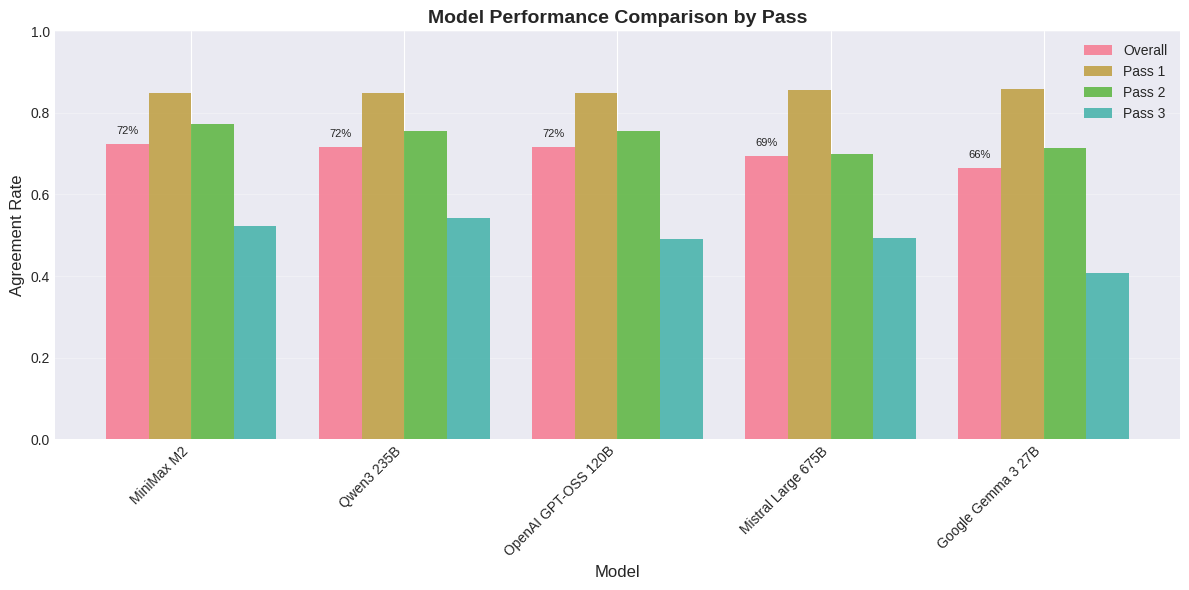

In [85]:
if model_performance.empty:
    print("No model performance data to visualize.")
else:
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(model_performance))
    width = 0.2

    ax.bar(x - width*1.5, model_performance['avg_agreement'], width, label='Overall', alpha=0.8)
    ax.bar(x - width*0.5, model_performance['pass1_agreement'], width, label='Pass 1', alpha=0.8)
    ax.bar(x + width*0.5, model_performance['pass2_agreement'], width, label='Pass 2', alpha=0.8)
    ax.bar(x + width*1.5, model_performance['pass3_agreement'], width, label='Pass 3', alpha=0.8)

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Agreement Rate', fontsize=12)
    ax.set_title('Model Performance Comparison by Pass', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_performance['model_name'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for i, (_, row) in enumerate(model_performance.iterrows()):
        ax.text(i - width*1.5, row['avg_agreement'] + 0.02, f"{row['avg_agreement']:.0%}", 
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

### 5.2 Field Type Agreement Heatmap

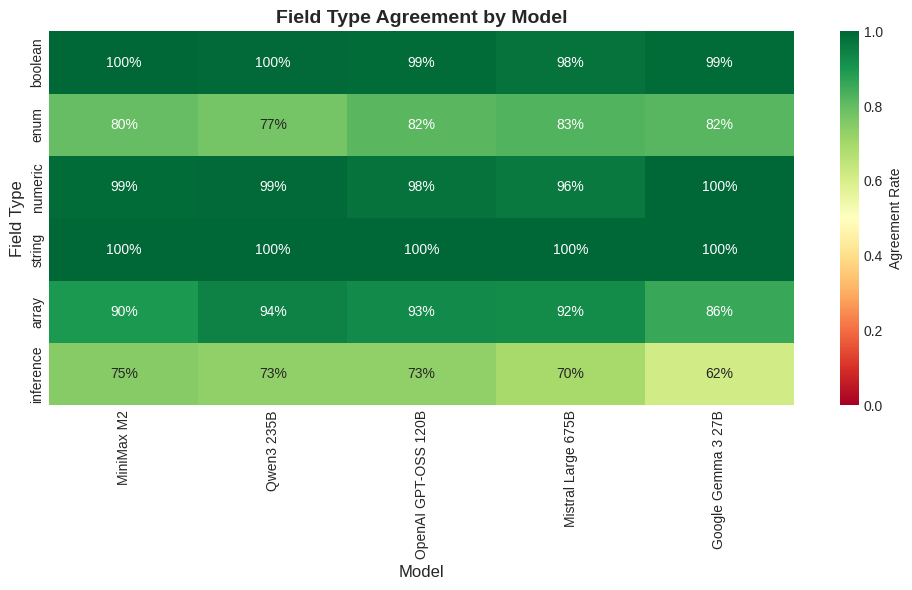

In [86]:
if not job_evaluations or model_performance.empty:
    print("No data available for field type heatmap.")
else:
    # Build field type x model heatmap
    field_type_model_data = defaultdict(lambda: defaultdict(list))

    for job_eval in job_evaluations:
        for field_eval in job_eval.field_evaluations:
            ft = field_eval.field_type
            for model_id in job_eval.model_performance.keys():
                # Check if model agrees with consensus
                is_outlier = model_id in field_eval.outlier_models
                field_type_model_data[ft][model_id].append(0 if is_outlier else 1)

    # Convert to DataFrame
    heatmap_data = []
    for ft in field_type_model_data.keys():
        row = {'field_type': ft}
        for model_id in model_performance['model_id']:
            model_name = MODEL_NAMES.get(model_id, model_id)
            agreements = field_type_model_data[ft][model_id]
            row[model_name] = np.mean(agreements) if agreements else 0
        heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data)
    heatmap_df = heatmap_df.set_index('field_type')

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, fmt='.0%', cmap='RdYlGn', vmin=0, vmax=1, 
                cbar_kws={'label': 'Agreement Rate'})
    plt.title('Field Type Agreement by Model', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Field Type', fontsize=12)
    plt.tight_layout()
    plt.show()

### 5.3 Pass-by-Pass Consensus Trends

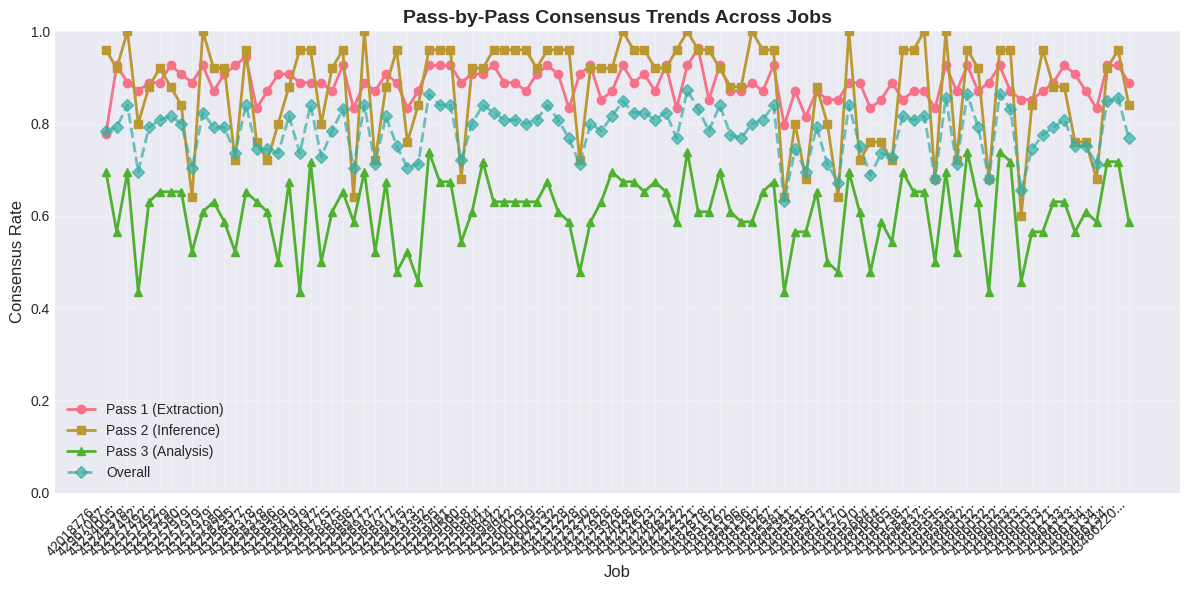

In [87]:
if pass_trends.empty:
    print("No pass trend data to visualize.")
else:
    fig, ax = plt.subplots(figsize=(12, 6))

    x = range(len(pass_trends))
    ax.plot(x, pass_trends['pass1_rate'], marker='o', label='Pass 1 (Extraction)', linewidth=2)
    ax.plot(x, pass_trends['pass2_rate'], marker='s', label='Pass 2 (Inference)', linewidth=2)
    ax.plot(x, pass_trends['pass3_rate'], marker='^', label='Pass 3 (Analysis)', linewidth=2)
    ax.plot(x, pass_trends['overall_rate'], marker='D', label='Overall', linewidth=2, linestyle='--', alpha=0.7)

    ax.set_xlabel('Job', fontsize=12)
    ax.set_ylabel('Consensus Rate', fontsize=12)
    ax.set_title('Pass-by-Pass Consensus Trends Across Jobs', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['job_id'][:8]}..." for _, row in pass_trends.iterrows()], rotation=45, ha='right')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

### 5.4 Consensus Distribution

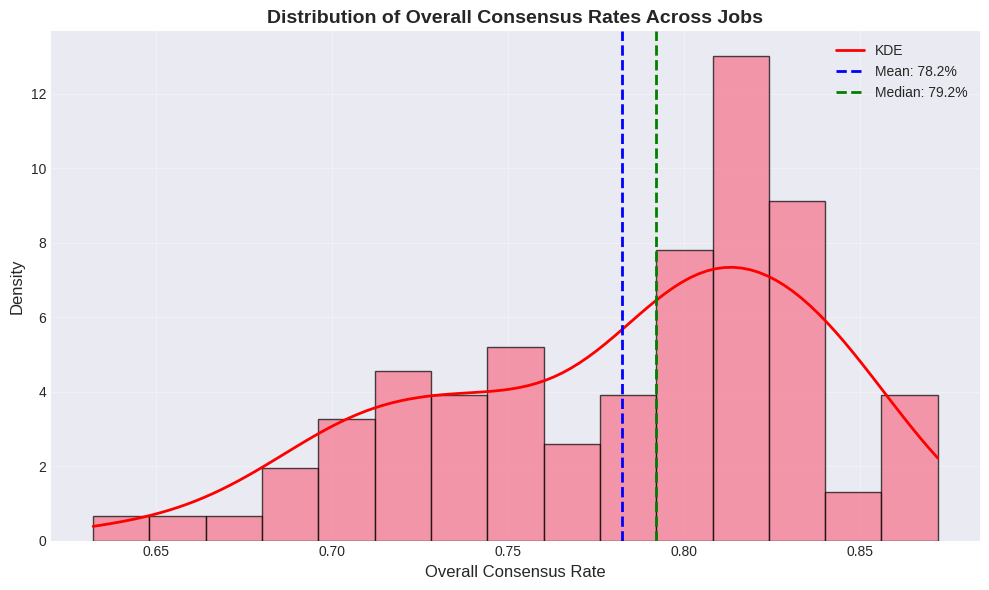

In [88]:
if not overall_metrics or 'consensus_distribution' not in overall_metrics:
    print("No consensus distribution data available.")
else:
    fig, ax = plt.subplots(figsize=(10, 6))

    consensus_dist = overall_metrics['consensus_distribution']
    ax.hist(consensus_dist, bins=15, alpha=0.7, edgecolor='black', density=True)

    # Add KDE
    from scipy import stats
    if len(consensus_dist) > 1:
        kde = stats.gaussian_kde(consensus_dist)
        x_range = np.linspace(min(consensus_dist), max(consensus_dist), 100)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

    # Add mean and median lines
    mean_val = np.mean(consensus_dist)
    median_val = np.median(consensus_dist)
    ax.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1%}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1%}')

    ax.set_xlabel('Overall Consensus Rate', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Distribution of Overall Consensus Rates Across Jobs', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

### 5.5 Top Low-Agreement Fields

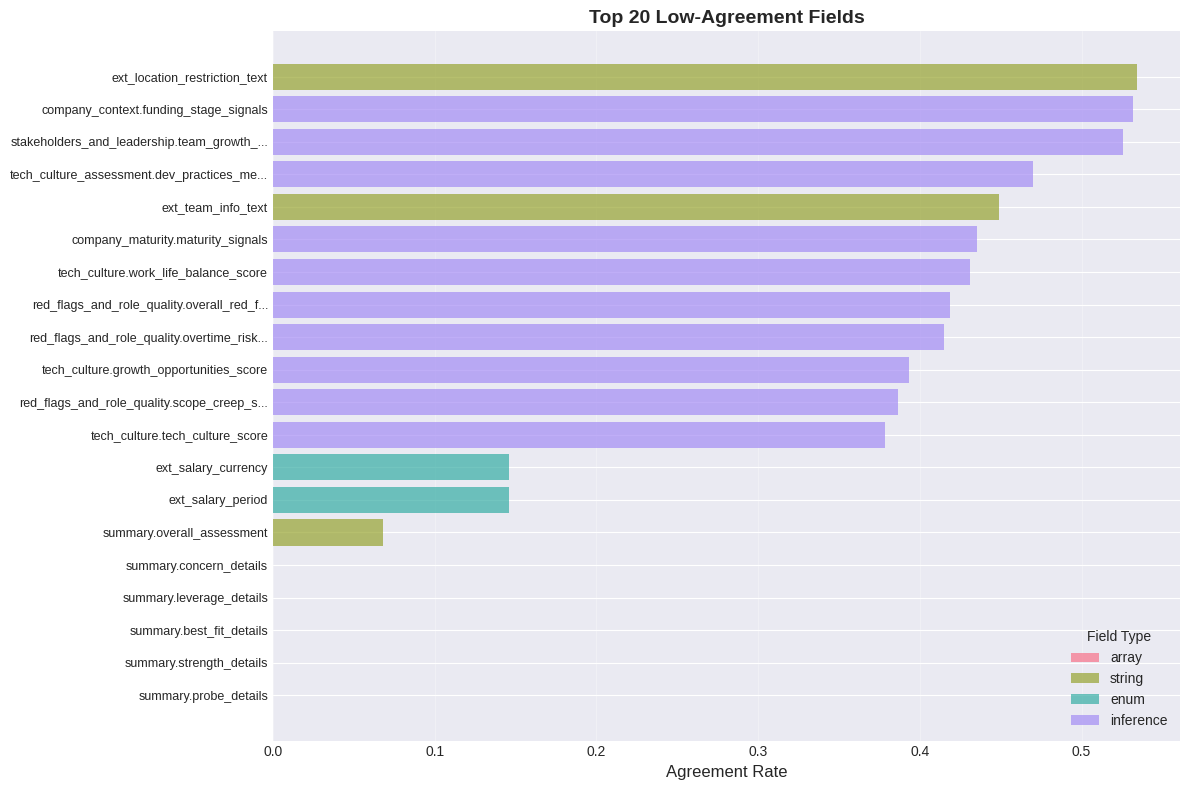

In [89]:
if not low_agreement_fields.empty:
    # Show top 20 worst fields
    top_low = low_agreement_fields.head(20).copy()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create color map by field type
    field_types = top_low['field_type'].unique()
    colors = sns.color_palette('husl', len(field_types))
    color_map = dict(zip(field_types, colors))
    bar_colors = [color_map[ft] for ft in top_low['field_type']]
    
    y_pos = range(len(top_low))
    ax.barh(y_pos, top_low['avg_agreement'], color=bar_colors, alpha=0.7)
    
    # Truncate field names for display
    field_labels = [f[:40] + '...' if len(f) > 40 else f for f in top_low['field_name']]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(field_labels, fontsize=9)
    ax.set_xlabel('Agreement Rate', fontsize=12)
    ax.set_title('Top 20 Low-Agreement Fields', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend for field types
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[ft], label=ft, alpha=0.7) for ft in field_types]
    ax.legend(handles=legend_elements, loc='lower right', title='Field Type')
    
    plt.tight_layout()
    plt.show()
else:
    print("No low-agreement fields to visualize")

### 5.6 Model Pairwise Agreement Heatmap

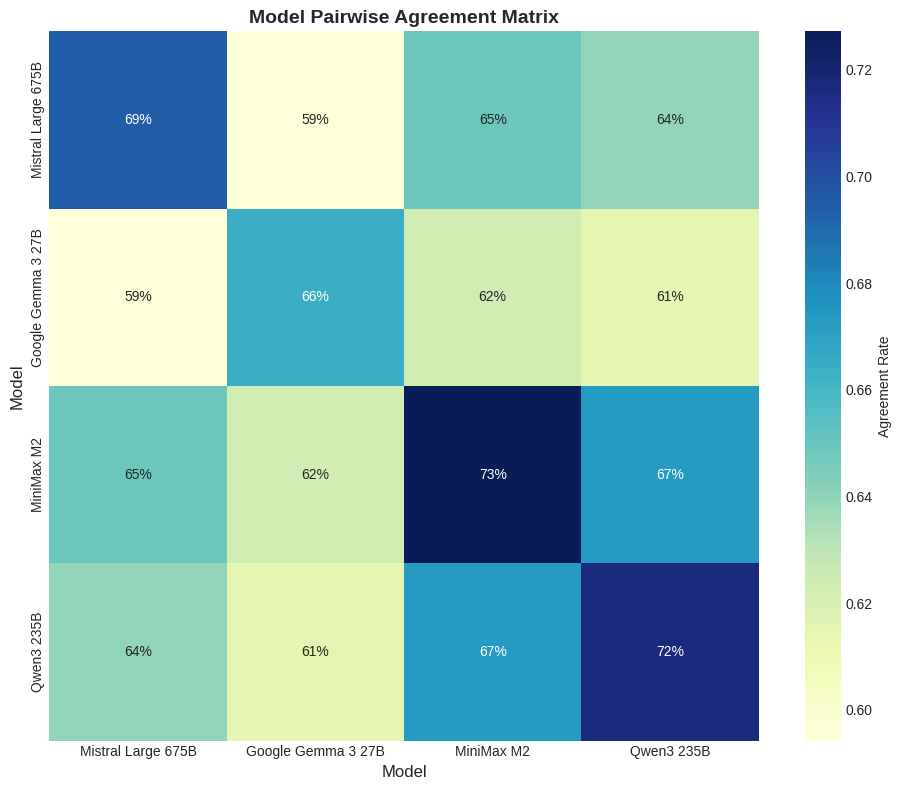

In [90]:
if not model_agreement_matrix.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(model_agreement_matrix, annot=True, fmt='.0%', cmap='YlGnBu', 
                square=True, cbar_kws={'label': 'Agreement Rate'})
    plt.title('Model Pairwise Agreement Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot compute model agreement matrix")

### 5.7 Field Type Agreement Distribution (Box Plot)

/tmp/ipykernel_639637/1227457594.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


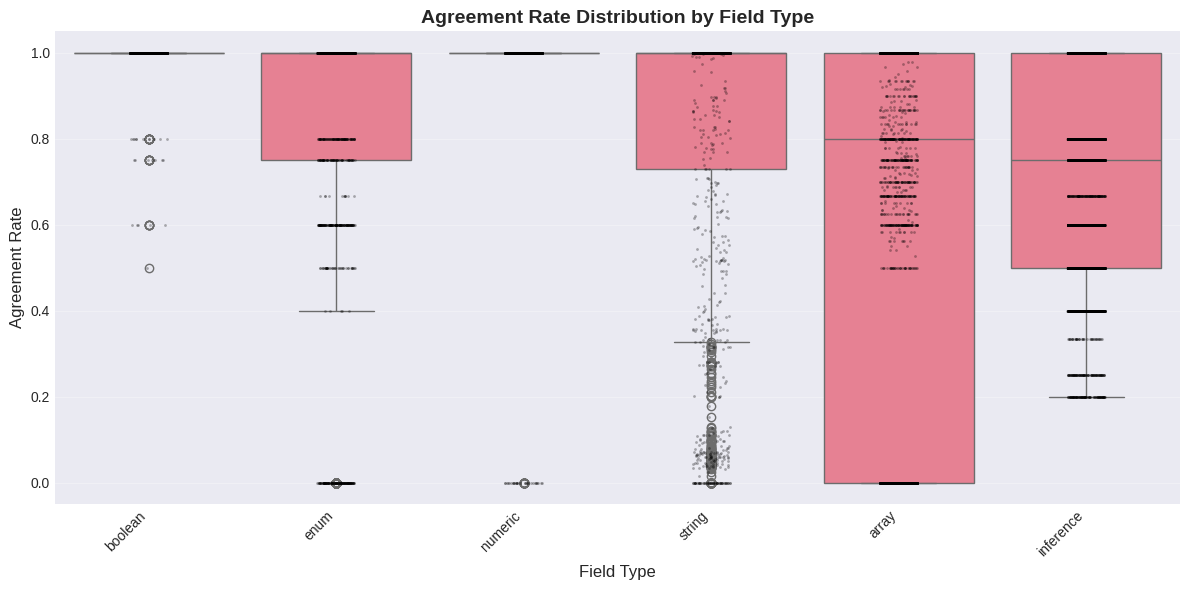

In [91]:
if not job_evaluations:
    print("No data available for field type distribution.")
else:
    # Collect agreement rates by field type
    field_type_distributions = defaultdict(list)

    for job_eval in job_evaluations:
        for field_eval in job_eval.field_evaluations:
            field_type_distributions[field_eval.field_type].append(field_eval.agreement_rate)

    # Convert to long-form DataFrame for seaborn
    box_data = []
    for ft, agreements in field_type_distributions.items():
        for agreement in agreements:
            box_data.append({'field_type': ft, 'agreement_rate': agreement})

    box_df = pd.DataFrame(box_data)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=box_df, x='field_type', y='agreement_rate', ax=ax)
    sns.stripplot(data=box_df, x='field_type', y='agreement_rate', ax=ax, 
                  color='black', alpha=0.3, size=2)

    ax.set_xlabel('Field Type', fontsize=12)
    ax.set_ylabel('Agreement Rate', fontsize=12)
    ax.set_title('Agreement Rate Distribution by Field Type', fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

### 5.8 Job-by-Job Consensus Variation

/tmp/ipykernel_639637/1117440677.py:31: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_639637/1117440677.py:31: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_639637/1117440677.py:31: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/home/geda/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/geda/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/geda/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) miss

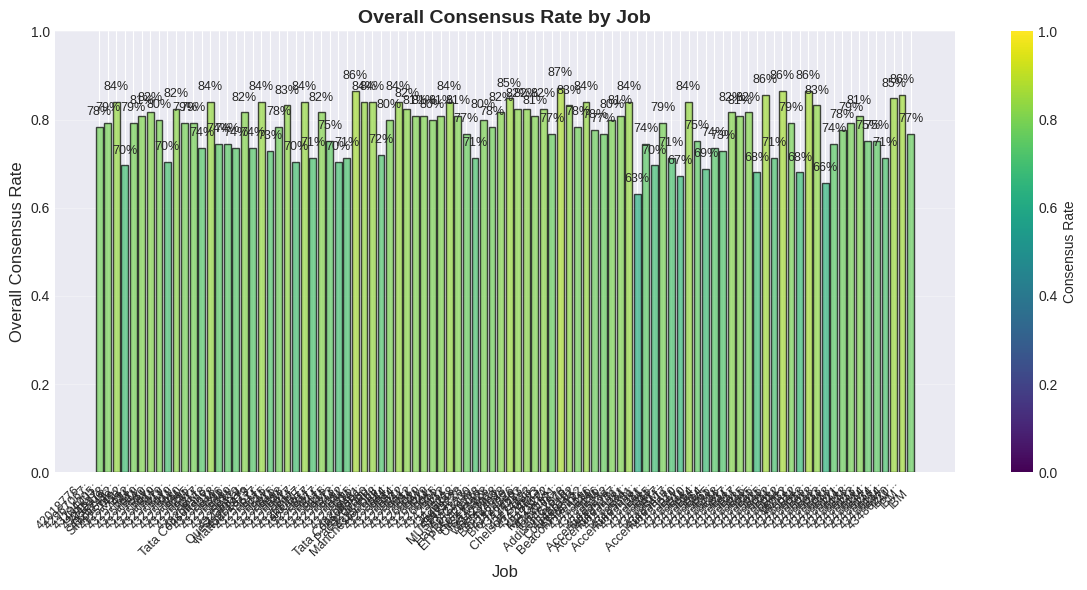

In [92]:
if pass_trends.empty:
    print("No data available for job consensus chart.")
else:
    fig, ax = plt.subplots(figsize=(12, 6))

    x = range(len(pass_trends))
    colors = plt.cm.viridis(pass_trends['overall_rate'])

    bars = ax.bar(x, pass_trends['overall_rate'], color=colors, alpha=0.7, edgecolor='black')

    ax.set_xlabel('Job', fontsize=12)
    ax.set_ylabel('Overall Consensus Rate', fontsize=12)
    ax.set_title('Overall Consensus Rate by Job', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['job_id'][:8]}...\n{row['company'][:15]}" 
                         for _, row in pass_trends.iterrows()], rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for i, (_, row) in enumerate(pass_trends.iterrows()):
        ax.text(i, row['overall_rate'] + 0.02, f"{row['overall_rate']:.0%}", 
                ha='center', va='bottom', fontsize=9)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Consensus Rate', fontsize=10)

    plt.tight_layout()
    plt.show()

## 6. Detailed Drill-Down Tables

### 6.1 All Fields Detail

In [93]:
# Create comprehensive field table
all_fields_data = []

for job_eval in job_evaluations:
    for field_eval in job_eval.field_evaluations:
        all_fields_data.append({
            'job_id': job_eval.job_id,
            'company': job_eval.company_name,
            'field_name': field_eval.field_name,
            'field_type': field_eval.field_type,
            'pass': field_eval.pass_number,
            'has_consensus': field_eval.has_consensus,
            'agreement_rate': field_eval.agreement_rate,
            'outliers': ', '.join(field_eval.outlier_models) if field_eval.outlier_models else 'none'
        })

all_fields_df = pd.DataFrame(all_fields_data)

if all_fields_df.empty:
    print("No field evaluation data available.")
else:
    print(f"\nTotal field evaluations: {len(all_fields_df)}")
    print("\nSample of all fields (first 20):")
    display(all_fields_df.head(20))

    # Can be filtered/sorted interactively
    print("\nThis table contains all field evaluations and can be filtered/sorted as needed.")


Total field evaluations: 12000

Sample of all fields (first 20):


,job_id,company,field_name,field_type,pass,has_consensus,agreement_rate,outliers
0,4201877691,UNFCU,ext_salary_disclosed,boolean,1,True,1.00,none
1,4201877691,UNFCU,ext_equity_mentioned,boolean,1,True,1.00,none
2,4201877691,UNFCU,ext_learning_budget_mentioned,boolean,1,False,0.50,"mistral, gemma"
3,4201877691,UNFCU,ext_conference_budget_mentioned,boolean,1,True,0.75,gemma
4,4201877691,UNFCU,ext_hardware_choice_mentioned,boolean,1,True,1.00,none
5,4201877691,UNFCU,ext_llm_genai_mentioned,boolean,1,True,1.00,none
6,4201877691,UNFCU,ext_feature_store_mentioned,boolean,1,True,1.00,none
7,4201877691,UNFCU,ext_salary_period,enum,1,True,1.00,none
8,4201877691,UNFCU,ext_salary_currency,enum,1,True,1.00,none
9,4201877691,UNFCU,ext_visa_sponsorship_stated,enum,1,True,1.00,none



This table contains all field evaluations and can be filtered/sorted as needed.


### 6.2 Model Outlier Analysis

In [94]:
# Analyze outlier patterns by model
outlier_data = defaultdict(lambda: defaultdict(int))

for job_eval in job_evaluations:
    for field_eval in job_eval.field_evaluations:
        for outlier_model in field_eval.outlier_models:
            key = f"{field_eval.field_type}|Pass{field_eval.pass_number}"
            outlier_data[outlier_model][key] += 1

# Convert to DataFrame
outlier_rows = []
for model_id, field_type_counts in outlier_data.items():
    for key, count in field_type_counts.items():
        field_type, pass_num = key.split('|')
        outlier_rows.append({
            'model': MODEL_NAMES.get(model_id, model_id),
            'field_type': field_type,
            'pass': pass_num,
            'outlier_count': count
        })

outlier_df = pd.DataFrame(outlier_rows)

print("\nMODEL OUTLIER ANALYSIS")
print("="*60)
print("Shows how often each model is an outlier by field type and pass")
print("="*60)

if outlier_df.empty:
    print("No outlier data available.")
else:
    outlier_df = outlier_df.sort_values(['model', 'outlier_count'], ascending=[True, False])
    display(outlier_df.head(30))


MODEL OUTLIER ANALYSIS
Shows how often each model is an outlier by field type and pass


,model,field_type,pass,outlier_count
12,Google Gemma 3 27B,inference,Pass3,1412
11,Google Gemma 3 27B,inference,Pass2,544
9,Google Gemma 3 27B,enum,Pass1,282
13,Google Gemma 3 27B,array,Pass3,276
10,Google Gemma 3 27B,array,Pass1,57
8,Google Gemma 3 27B,boolean,Pass1,6
14,Google Gemma 3 27B,numeric,Pass1,1
15,Google Gemma 3 27B,numeric,Pass3,1
20,MiniMax M2,inference,Pass3,674
19,MiniMax M2,inference,Pass2,307


### 6.3 Per-Job Summary

In [95]:
# Display the pass_trends DataFrame which has per-job summary
print("\nPER-JOB EVALUATION SUMMARY")
print("="*60)

if pass_trends.empty:
    print("No per-job data available.")
else:
    job_summary = pass_trends.copy()
    for col in ['pass1_rate', 'pass2_rate', 'pass3_rate', 'overall_rate']:
        job_summary[f"{col}_pct"] = job_summary[col].apply(lambda x: f"{x:.1%}")

    display_cols = ['job_id', 'job_title', 'company', 'overall_rate_pct', 
                    'pass1_rate_pct', 'pass2_rate_pct', 'pass3_rate_pct']
    display(job_summary[display_cols])


PER-JOB EVALUATION SUMMARY


,job_id,job_title,company,overall_rate_pct,pass1_rate_pct,pass2_rate_pct,pass3_rate_pct
0,4201877691,BI Data Engineer,UNFCU,78.4%,77.8%,96.0%,69.6%
1,4296706724,Senior Data Engineer II,ActBlue,79.2%,92.6%,92.0%,56.5%
2,4323400548,Senior Data Engineer,SimpliSafe,84.0%,88.9%,100.0%,69.6%
3,4324537833,Staff Data Engineer,Visa,69.6%,87.0%,80.0%,43.5%
4,4325749223,Data Engineer-Data Platforms-Azure,IBM,79.2%,88.9%,88.0%,63.0%
5,4325749256,Data Engineer-Data Platforms-Azure,IBM,80.8%,88.9%,92.0%,65.2%
6,4325749282,Application Developer-Process Management (BPM),IBM,81.6%,92.6%,88.0%,65.2%
7,4325757965,Data Engineer-Business Intelligence,IBM,80.0%,90.7%,84.0%,65.2%
8,4325758017,Data Scientist-Advanced Analytics,IBM,70.4%,88.9%,64.0%,52.2%
9,4325797974,Data Engineer-Data Modeling,IBM,82.4%,92.6%,100.0%,60.9%


## 7. Statistical Analysis

### 7.1 Correlation Analysis

In [96]:
from scipy.stats import pearsonr, spearmanr

print("\nCORRELATION ANALYSIS")
print("="*60)

if pass_trends.empty or len(pass_trends) < 3:
    print("Insufficient data for correlation analysis (need at least 3 jobs).")
else:
    correlations = []

    # Overall vs Pass rates
    for pass_col in ['pass1_rate', 'pass2_rate', 'pass3_rate']:
        r, p = pearsonr(pass_trends['overall_rate'], pass_trends[pass_col])
        correlations.append({
            'metric_1': 'overall_rate',
            'metric_2': pass_col,
            'pearson_r': r,
            'p_value': p,
            'significant': 'Yes' if p < 0.05 else 'No'
        })

    # Agreement vs Outlier rate (from model performance)
    if len(model_performance) > 1:
        r, p = pearsonr(model_performance['avg_agreement'], model_performance['outlier_rate'])
        correlations.append({
            'metric_1': 'agreement_rate',
            'metric_2': 'outlier_rate',
            'pearson_r': r,
            'p_value': p,
            'significant': 'Yes' if p < 0.05 else 'No'
        })

    corr_df = pd.DataFrame(correlations)
    display(corr_df)

    print("\nInterpretation:")
    print("- Strong positive correlation (r > 0.7): Variables move together")
    print("- Strong negative correlation (r < -0.7): Variables move opposite")
    print("- Weak correlation (-0.3 < r < 0.3): Little linear relationship")


CORRELATION ANALYSIS


,metric_1,metric_2,pearson_r,p_value,significant
0,overall_rate,pass1_rate,0.638647,2.548033e-12,Yes
1,overall_rate,pass2_rate,0.873179,4.294963e-31,Yes
2,overall_rate,pass3_rate,0.900957,7.479617e-36,Yes
3,agreement_rate,outlier_rate,-0.978909,3.665144e-03,Yes



Interpretation:
- Strong positive correlation (r > 0.7): Variables move together
- Strong negative correlation (r < -0.7): Variables move opposite
- Weak correlation (-0.3 < r < 0.3): Little linear relationship


### 7.2 Field Type Impact

In [97]:
print("\nFIELD TYPE IMPACT ANALYSIS")
print("="*60)
print("Which field types most impact overall consensus?\n")

if field_type_metrics.empty:
    print("No field type data available.")
else:
    # Calculate weighted impact (count * avg_agreement)
    impact_df = field_type_metrics.copy()
    impact_df['impact_score'] = impact_df['total_count'] * impact_df['avg_agreement']
    impact_df['weight'] = impact_df['total_count'] / impact_df['total_count'].sum()

    impact_df = impact_df.sort_values('impact_score', ascending=False)

    display(impact_df[['field_type', 'total_count', 'avg_agreement', 'weight', 'impact_score']])

    print("\nInterpretation:")
    print("- Impact score = count x avg_agreement")
    print("- Higher impact score means field type has more influence on overall consensus")
    print("- Weight shows proportion of total fields")


FIELD TYPE IMPACT ANALYSIS
Which field types most impact overall consensus?



,field_type,total_count,avg_agreement,weight,impact_score
5,inference,5088,0.701104,0.424,3567.216667
4,array,2304,0.648089,0.192,1493.196699
1,enum,1536,0.809983,0.128,1244.133333
3,string,1344,0.804672,0.112,1081.479223
2,numeric,1056,0.971591,0.088,1026.000000
0,boolean,672,0.990402,0.056,665.550000



Interpretation:
- Impact score = count x avg_agreement
- Higher impact score means field type has more influence on overall consensus
- Weight shows proportion of total fields


### 7.3 Model Specialization

In [98]:
print("\nMODEL SPECIALIZATION BY FIELD TYPE")
print("="*60)
print("Which models excel at which field types?\n")

# Check if heatmap_df exists and is not empty
try:
    if heatmap_df.empty:
        print("Insufficient data for specialization analysis")
    else:
        # Find best model for each field type
        best_models = []
        for ft in heatmap_df.index:
            best_model = heatmap_df.loc[ft].idxmax()
            best_score = heatmap_df.loc[ft].max()
            best_models.append({
                'field_type': ft,
                'best_model': best_model,
                'agreement_rate': best_score
            })
        
        specialization_df = pd.DataFrame(best_models)
        specialization_df['agreement_rate'] = specialization_df['agreement_rate'].apply(lambda x: f"{x:.1%}")
        
        display(specialization_df)
        
        print("\nModel Expertise Summary:")
        expertise_count = specialization_df['best_model'].value_counts()
        for model, count in expertise_count.items():
            print(f"  {model}: Best at {count} field type(s)")
except NameError:
    print("Insufficient data for specialization analysis (heatmap not computed)")


MODEL SPECIALIZATION BY FIELD TYPE
Which models excel at which field types?



,field_type,best_model,agreement_rate
0,boolean,MiniMax M2,100.0%
1,enum,Mistral Large 675B,82.7%
2,numeric,Google Gemma 3 27B,99.8%
3,string,MiniMax M2,100.0%
4,array,Qwen3 235B,94.5%
5,inference,MiniMax M2,75.0%



Model Expertise Summary:
  MiniMax M2: Best at 3 field type(s)
  Mistral Large 675B: Best at 1 field type(s)
  Google Gemma 3 27B: Best at 1 field type(s)
  Qwen3 235B: Best at 1 field type(s)


## 8. Export & Summary

### 8.1 Export Key Tables to CSV

In [99]:
# Create exports directory if it doesn't exist
export_dir = Path('exports')
export_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export key tables
exports = {
    'model_performance': model_performance,
    'field_type_metrics': field_type_metrics,
    'low_agreement_fields': low_agreement_fields,
    'high_agreement_fields': high_agreement_fields,
    'pass_trends': pass_trends,
    'all_fields': all_fields_df
}
#
#print("Exporting tables to CSV...")
#for name, df in exports.items():
#    if not df.empty:
##        filepath = export_dir / f"{name}_{timestamp}.csv"
#        df.to_csv(filepath, index=False)
#        print(f"  ✓ Exported: {filepath}")
#
#int(f"\nAll exports saved to: {export_dir}/")

### 8.2 Generate Executive Summary

In [100]:
# Generate markdown summary
if not overall_metrics or model_performance.empty or field_type_metrics.empty:
    print("Insufficient data to generate executive summary.")
else:
    best_model = model_performance.iloc[0]['model_name']
    worst_model = model_performance.iloc[-1]['model_name']
    best_field_type = field_type_metrics.iloc[0]['field_type']
    worst_field_type = field_type_metrics.iloc[-1]['field_type']

    summary_md = f"""
# Inter-Model Evaluation Analysis Summary

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Overview
- **Jobs Analyzed:** {overall_metrics['total_jobs']}
- **Total Fields Evaluated:** {overall_metrics['total_fields']}
- **Overall Consensus Rate:** {overall_metrics['overall_consensus_rate']:.1%}

## Pass-by-Pass Performance
- **Pass 1 (Extraction):** {overall_metrics['pass1_consensus_rate']:.1%}
- **Pass 2 (Inference):** {overall_metrics['pass2_consensus_rate']:.1%}
- **Pass 3 (Analysis):** {overall_metrics['pass3_consensus_rate']:.1%}

## Key Findings

### Model Performance
- **Best Performer:** {best_model} (Score: {model_performance.iloc[0]['intermodel_score']:.1f})
- **Needs Improvement:** {worst_model} (Score: {model_performance.iloc[-1]['intermodel_score']:.1f})

### Field Type Analysis
- **Highest Agreement:** {best_field_type} ({field_type_metrics.iloc[0]['avg_agreement']:.1%})
- **Lowest Agreement:** {worst_field_type} ({field_type_metrics.iloc[-1]['avg_agreement']:.1%})
- **Gap Fields:** {len(low_agreement_fields)} fields with <60% agreement

### Recommendations
1. **Focus on improving:** {worst_field_type} field types (lowest agreement)
2. **Review models:** Investigate why {worst_model} has lower performance
3. **Address gaps:** Review {len(low_agreement_fields)} low-agreement fields for prompt improvements
4. **Leverage strengths:** {best_model} shows strong performance, consider as reference

## Next Steps
- Review detailed field-level analysis for specific improvements
- Consider adding more models or adjusting prompts for low-agreement fields
- Monitor trends as new jobs are added
"""

    # Save summary
    summary_path = export_dir / f"executive_summary_{timestamp}.md"
    with open(summary_path, 'w') as f:
        f.write(summary_md)

    print(f"Executive summary saved to: {summary_path}")
    print("\n" + "="*60)
    print(summary_md)
    print("="*60)

Executive summary saved to: exports/executive_summary_20251211_204018.md


# Inter-Model Evaluation Analysis Summary

**Generated:** 2025-12-11 20:40:18

## Overview
- **Jobs Analyzed:** 96
- **Total Fields Evaluated:** 12000
- **Overall Consensus Rate:** 78.2%

## Pass-by-Pass Performance
- **Pass 1 (Extraction):** 88.6%
- **Pass 2 (Inference):** 87.5%
- **Pass 3 (Analysis):** 61.0%

## Key Findings

### Model Performance
- **Best Performer:** MiniMax M2 (Score: 77.2)
- **Needs Improvement:** Google Gemma 3 27B (Score: 71.3)

### Field Type Analysis
- **Highest Agreement:** boolean (99.0%)
- **Lowest Agreement:** array (64.8%)
- **Gap Fields:** 27 fields with <60% agreement

### Recommendations
1. **Focus on improving:** array field types (lowest agreement)
2. **Review models:** Investigate why Google Gemma 3 27B has lower performance
3. **Address gaps:** Review 27 low-agreement fields for prompt improvements
4. **Leverage strengths:** MiniMax M2 shows strong performance, consider as 

### 8.3 Key Insights

In [101]:
print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

if not overall_metrics:
    print("No data available to generate insights.")
else:
    insights = []

    # Insight 1: Overall performance
    if overall_metrics['overall_consensus_rate'] >= 0.8:
        insights.append(f"✓ Strong overall consensus ({overall_metrics['overall_consensus_rate']:.1%}) indicates good model alignment")
    elif overall_metrics['overall_consensus_rate'] >= 0.6:
        insights.append(f"⚠ Moderate consensus ({overall_metrics['overall_consensus_rate']:.1%}) - room for improvement")
    else:
        insights.append(f"✗ Low consensus ({overall_metrics['overall_consensus_rate']:.1%}) - significant gaps to address")

    # Insight 2: Pass variation
    pass_rates = [overall_metrics['pass1_consensus_rate'], 
                  overall_metrics['pass2_consensus_rate'], 
                  overall_metrics['pass3_consensus_rate']]
    pass_std = np.std(pass_rates)
    if pass_std > 0.15:
        insights.append(f"⚠ High variation between passes (σ={pass_std:.2f}) - some passes need attention")
    else:
        insights.append(f"✓ Consistent performance across passes (σ={pass_std:.2f})")

    # Insight 3: Model spread
    if len(model_performance) > 1:
        score_spread = model_performance['intermodel_score'].max() - model_performance['intermodel_score'].min()
        if score_spread > 10:
            insights.append(f"⚠ Large spread in model scores ({score_spread:.1f} points) - consider model selection")
        else:
            insights.append(f"✓ Models perform similarly (spread: {score_spread:.1f} points)")

    # Insight 4: Gap fields
    if len(low_agreement_fields) > 0:
        gap_pct = len(low_agreement_fields) / overall_metrics['total_fields'] * 100
        insights.append(f"⚠ {len(low_agreement_fields)} gap fields ({gap_pct:.1f}% of total) need review")
    else:
        insights.append("✓ No significant gap fields - strong alignment across all fields")

    # Insight 5: Field type challenges
    if not field_type_metrics.empty:
        worst_ft = field_type_metrics.iloc[-1]
        if worst_ft['avg_agreement'] < 0.6:
            insights.append(f"⚠ {worst_ft['field_type']} fields are challenging ({worst_ft['avg_agreement']:.1%} agreement)")

    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")

print("\n" + "="*60)
print(f"Analysis completed at: {datetime.now()}")
print("="*60)


KEY INSIGHTS
1. ⚠ Moderate consensus (78.2%) - room for improvement
2. ✓ Consistent performance across passes (σ=0.13)
3. ✓ Models perform similarly (spread: 6.0 points)
4. ⚠ 27 gap fields (0.2% of total) need review

Analysis completed at: 2025-12-11 20:40:18.663855


---

## Analysis Complete!

This notebook has provided:
- Aggregate metrics across all jobs
- Model performance comparisons
- Field type analysis
- 8 comprehensive visualizations
- Detailed drill-down tables
- Statistical insights
- Exported results to CSV

**Next time you run this notebook:**
- It will automatically discover any new jobs added to `data/local/`
- All metrics and visualizations will update accordingly
- New exports will be timestamped to avoid overwriting
